<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin : TP2 de data analytics


## Préparation des données utiles pour le TP2 :

###On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages (environ 700 000).
Si un fichier CSV commençant par **"data_TP2_"** existe, alors on n'exécute pas le code de récupération des messages.

In [16]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/data_TP2_*.csv")

if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")
else:
    # Sinon on en crée un nouveau
    date = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{PROJECT_ROOT}/data_TP2_{date}.csv"
    print(f"Aucun fichier existant. Nouveau fichier : {output_file}")


    print(f"Connexion à {HOST}:{PORT} ...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        print("Connecté ! Réception des messages ADS-B...\n")

        # Teste si le fichier existe déjà (on ne réécrit pas le header)
        file_exists = os.path.isfile(output_file) and os.path.getsize(output_file) > 0

        with open(output_file, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",")

            # Écrit le header seulement si le fichier est nouveau/vide
            if not file_exists:
                writer.writerow(cols)

            try:
                for i in range(120000):
                    data = s.recv(1024).decode(errors="ignore")

                    for line in data.strip().split("\n"):
                        if line.startswith("MSG"):
                            fields = line.split(",")

                            # Complète si trop court
                            if len(fields) < len(cols):
                                fields += [""] * (len(cols) - len(fields))

                            writer.writerow(fields)

                    if i % 5000 == 0:
                        print(f"{i} itérations traitées")

            except KeyboardInterrupt:
                print("\nArrêt manuel par l’utilisateur.")
            except Exception as e:
                print("Erreur :", e)

    print(f"\nDonnées enregistrées dans : {output_file}")


Fichier existant trouvé : /content/Data_analytics_aircraft_messages/data_TP2_20251120_081609.csv


###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [17]:
df = pd.read_csv(output_file)
#df = df[0].str.split(",", expand=True)

/tmp/ipython-input-1259883730.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file)


Analyse initiale du dataset :

In [18]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3.0,NaN,NaN,4B1E44,NaN,2025/11/20,08:16:09.371,2025/11/20,08:16:09.371,...,99.0,218.0,47.163,7.35615,NaN,NaN,0.0,0.0,0.0,0.0
1,MSG,3.0,NaN,NaN,3D2A42,NaN,2025/11/20,08:16:09.374,2025/11/20,08:16:09.374,...,256.0,115.0,48.5719,12.19607,NaN,NaN,0.0,0.0,0.0,0.0
2,MSG,3.0,NaN,NaN,48415E,NaN,2025/11/20,08:16:09.375,2025/11/20,08:16:09.375,...,237.0,328.0,52.13917,-1.40272,NaN,NaN,0.0,0.0,0.0,0.0
3,MSG,3.0,NaN,NaN,4D2411,NaN,2025/11/20,08:16:09.377,2025/11/20,08:16:09.377,...,376.0,6.0,49.98868,9.47375,NaN,NaN,0.0,0.0,0.0,0.0
4,MSG,3.0,NaN,NaN,3C70C7,NaN,2025/11/20,08:16:09.381,2025/11/20,08:16:09.381,...,427.0,121.0,49.75452,9.17745,NaN,NaN,0.0,0.0,0.0,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714736 entries, 0 to 714735
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MessageType       714736 non-null  object 
 1   TransmissionType  712773 non-null  float64
 2   SessionID         0 non-null       float64
 3   AircraftID        0 non-null       float64
 4   HexIdent          709325 non-null  object 
 5   FlightID          0 non-null       float64
 6   DateGenerated     703991 non-null  object 
 7   TimeGenerated     697186 non-null  object 
 8   DateLogged        680704 non-null  object 
 9   TimeLogged        670846 non-null  object 
 10  Callsign          662945 non-null  object 
 11  Altitude          655047 non-null  float64
 12  GroundSpeed       647796 non-null  float64
 13  Track             638399 non-null  float64
 14  Latitude          631626 non-null  object 
 15  Longitude         625660 non-null  object 
 16  VerticalRate      0 

In [14]:
df.describe()

,TransmissionType,SessionID,AircraftID,FlightID,Altitude,GroundSpeed,Track,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,712773.0,0.0,0.0,0.0,655047.000000,647796.000000,638399.000000,0.0,0.0,618205.0,616407.0,614453.0,612462.0
mean,3.0,NaN,NaN,NaN,12266.097300,262.072833,171.974474,NaN,NaN,0.0,0.0,0.0,0.0
std,0.0,NaN,NaN,NaN,10041.463142,121.816976,103.074210,NaN,NaN,0.0,0.0,0.0,0.0
min,3.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0
25%,3.0,NaN,NaN,NaN,4518.500000,182.000000,90.000000,NaN,NaN,0.0,0.0,0.0,0.0
50%,3.0,NaN,NaN,NaN,10344.000000,277.000000,168.000000,NaN,NaN,0.0,0.0,0.0,0.0
75%,3.0,NaN,NaN,NaN,15940.000000,347.000000,259.000000,NaN,NaN,0.0,0.0,0.0,0.0
max,3.0,NaN,NaN,NaN,215033.000000,729.000000,360.000000,NaN,NaN,0.0,0.0,0.0,0.0


###1.2. Extraction des colonnes utiles

In [62]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,655047.000000,647796.000000,638399.000000,631605.000000,625539.000000,687501
mean,12266.097300,262.072833,171.974474,47.376595,6.597897,2025-11-20 08:33:25.427607552
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:16:09.371000
25%,4518.500000,182.000000,90.000000,45.674580,2.160425,2025-11-20 08:25:01.478000128
50%,10344.000000,277.000000,168.000000,50.051700,7.852900,2025-11-20 08:33:30.935000064
75%,15940.000000,347.000000,259.000000,51.710150,10.785525,2025-11-20 08:41:55.857999872
max,215033.000000,729.000000,360.000000,70.327430,175.736980,2025-11-20 08:50:18.680000
std,10041.463142,121.816976,103.074210,12.500764,11.179713,NaN


In [63]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714736 entries, 0 to 714735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   icao          709325 non-null  object        
 1   registration  662945 non-null  object        
 2   altitude      655047 non-null  float64       
 3   velocity      647796 non-null  float64       
 4   heading       638399 non-null  float64       
 5   lat           631605 non-null  float64       
 6   lon           625539 non-null  float64       
 7   timestamp     687501 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 43.6+ MB


In [64]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,4B1E44,ICA4B1E44,3353.0,99.0,218.0,47.16300,7.35615,2025-11-20 08:16:09.371
1,3D2A42,ICA3D2A42,22049.0,256.0,115.0,48.57190,12.19607,2025-11-20 08:16:09.374
2,48415E,PH-BXE,6546.0,237.0,328.0,52.13917,-1.40272,2025-11-20 08:16:09.375
3,4D2411,ICA4D2411,26568.0,376.0,6.0,49.98868,9.47375,2025-11-20 08:16:09.377
4,3C70C7,ICA3C70C7,18490.0,427.0,121.0,49.75452,9.17745,2025-11-20 08:16:09.381


## On sélectionne maintenant un avion en particulier

On trie ensuite par timestamp pour obtenir les messages triés en fonction du temps (du plus vieux au plus récent)

In [68]:
# On teste pour plusieurs avions au cas où on observe des erreurs.
icao_sample = df_parsed['icao'].value_counts().index[0]
icao_sample2 = df_parsed['icao'].value_counts().index[1]
icao_sample3 = df_parsed['icao'].value_counts().index[2]
icao_sample4 = df_parsed['icao'].value_counts().index[3]
icao_sample5 = df_parsed['icao'].value_counts().index[4]
print(icao_sample)
print(icao_sample2)
print(icao_sample3)
print(icao_sample4)
print(icao_sample5)
flight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')
flight.info()

043EA0
4D2537
404A7E
4D251B
E80421
<class 'pandas.core.frame.DataFrame'>
Index: 5175 entries, 75 to 714121
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          5175 non-null   object        
 1   registration  4852 non-null   object        
 2   altitude      4771 non-null   float64       
 3   velocity      4700 non-null   float64       
 4   heading       4617 non-null   float64       
 5   lat           4574 non-null   float64       
 6   lon           4535 non-null   float64       
 7   timestamp     5035 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 363.9+ KB


On tâche de nettoyer un peu le dataset sur les valeurs manquantes

In [69]:
flight.dropna(inplace=True)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4535 entries, 75 to 714417
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          4535 non-null   object        
 1   registration  4535 non-null   object        
 2   altitude      4535 non-null   float64       
 3   velocity      4535 non-null   float64       
 4   heading       4535 non-null   float64       
 5   lat           4535 non-null   float64       
 6   lon           4535 non-null   float64       
 7   timestamp     4535 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 318.9+ KB


In [70]:
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
75,4D2537,ICA4D2537,8508.0,175.0,209.0,51.18972,6.24218,2025-11-20 08:16:09.637
149,4D2537,ICA4D2537,8538.0,175.0,209.0,51.18905,6.24157,2025-11-20 08:16:09.840
595,4D2537,ICA4D2537,8555.0,174.0,209.0,51.18838,6.24100,2025-11-20 08:16:11.330
770,4D2537,ICA4D2537,8558.0,174.0,209.0,51.18833,6.24093,2025-11-20 08:16:11.859
1086,4D2537,ICA4D2537,8590.0,174.0,209.0,51.18762,6.24032,2025-11-20 08:16:12.731
1444,4D2537,ICA4D2537,8661.0,174.0,209.0,51.18618,6.23907,2025-11-20 08:16:13.696
1794,4D2537,ICA4D2537,8681.0,174.0,209.0,51.18553,6.23852,2025-11-20 08:16:14.822
1807,4D2537,ICA4D2537,8684.0,175.0,209.0,51.18553,6.23850,2025-11-20 08:16:14.867
2107,4D2537,ICA4D2537,8711.0,174.0,209.0,51.18480,6.23782,2025-11-20 08:16:15.794
2279,4D2537,ICA4D2537,8718.0,174.0,209.0,51.18478,6.23785,2025-11-20 08:16:16.262


1.a Extraction des variables dynamiques

**Calcul de l'accélération instantanée**

On calcule l'accélération entre deux instances de messages collectés.



In [71]:
def calculate_acceleration(velocity_1, velocity_2, timestamp_1, timestamp_2):
    if pd.isnull(velocity_1) or pd.isnull(velocity_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (velocity_2 - velocity_1) / (timestamp_2 - timestamp_1).total_seconds()

# On shift de 50 pour avoir des données suffisamment espacées dans le temps
flight['prev_velocity']=flight['velocity'].shift(50)
flight['prev_timestamp']=flight['timestamp'].shift(50)
flight['acceleration'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_velocity'], row['velocity'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_velocity']) else None,
    axis=1
)

**On calcule à présent la variation de cap (Heading)**

Cette fois, on calcule la variation de cap entre deux instances de messages collectés

In [72]:
def calculate_heading_variation(heading_1, heading_2, timestamp_1, timestamp_2):
    if pd.isnull(heading_1) or pd.isnull(heading_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (heading_2 - heading_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_heading']=flight['heading'].shift(50)
flight['heading_var'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_heading'], row['heading'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_heading']) else None,
    axis=1
)

**On calcule à présent la vitesse verticale (en ft par minutes)**

Pour cela, on calcule la différence d'altitude entre deux lignes et on normalise pour une différence entre des intervalles de 60 secondes

In [73]:
def calculate_vertical_speed(altitude_1, altitude_2, timestamp_1, timestamp_2):
    if pd.isnull(altitude_1) or pd.isnull(altitude_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return 60.0 * (altitude_2 - altitude_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_altitude']=flight['altitude'].shift(50)
flight['vertical_speed'] = flight.apply(
    lambda row: calculate_vertical_speed(
        row['prev_altitude'], row['altitude'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_altitude']) else None,
    axis=1
)

In [74]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4535 entries, 75 to 714417
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            4535 non-null   object        
 1   registration    4535 non-null   object        
 2   altitude        4535 non-null   float64       
 3   velocity        4535 non-null   float64       
 4   heading         4535 non-null   float64       
 5   lat             4535 non-null   float64       
 6   lon             4535 non-null   float64       
 7   timestamp       4535 non-null   datetime64[ns]
 8   prev_velocity   4485 non-null   float64       
 9   prev_timestamp  4485 non-null   datetime64[ns]
 10  acceleration    4485 non-null   float64       
 11  prev_heading    4485 non-null   float64       
 12  heading_var     4485 non-null   float64       
 13  prev_altitude   4485 non-null   float64       
 14  vertical_speed  4485 non-null   float64       
dtypes: dat

## On calcule enfin la distance parcourue avec la méthode Haversine

In [75]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000.0  # Rayon de la Terre en mètres

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

first_lat = flight['lat'].iloc[0]
first_lon = flight['lon'].iloc[0]
flight['distance'] = haversine_vectorized(first_lat, first_lon, flight['lat'], flight['lon'])

In [76]:
flight.dropna(inplace=True)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
12488,4D2537,ICA4D2537,9745.0,171.0,209.0,51.16185,6.21752,2025-11-20 08:16:49.155,175.0,2025-11-20 08:16:09.637,-0.101220,209.0,0.0,8508.0,1878.131484,3543.881498
12809,4D2537,ICA4D2537,9771.0,171.0,209.0,51.16117,6.21692,2025-11-20 08:16:50.189,175.0,2025-11-20 08:16:09.840,-0.099135,209.0,0.0,8538.0,1833.502689,3630.298158
12963,4D2537,ICA4D2537,9817.0,171.0,209.0,51.16050,6.21627,2025-11-20 08:16:50.646,174.0,2025-11-20 08:16:11.330,-0.076305,209.0,0.0,8555.0,1925.933462,3717.435060
13120,4D2537,ICA4D2537,9824.0,171.0,209.0,51.16050,6.21633,2025-11-20 08:16:51.469,174.0,2025-11-20 08:16:11.859,-0.075738,209.0,0.0,8558.0,1917.697551,3715.404500
13406,4D2537,ICA4D2537,9853.0,171.0,209.0,51.15982,6.21572,2025-11-20 08:16:52.372,174.0,2025-11-20 08:16:12.731,-0.075679,209.0,0.0,8590.0,1911.657123,3802.159924


In [77]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4485 entries, 12488 to 714417
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            4485 non-null   object        
 1   registration    4485 non-null   object        
 2   altitude        4485 non-null   float64       
 3   velocity        4485 non-null   float64       
 4   heading         4485 non-null   float64       
 5   lat             4485 non-null   float64       
 6   lon             4485 non-null   float64       
 7   timestamp       4485 non-null   datetime64[ns]
 8   prev_velocity   4485 non-null   float64       
 9   prev_timestamp  4485 non-null   datetime64[ns]
 10  acceleration    4485 non-null   float64       
 11  prev_heading    4485 non-null   float64       
 12  heading_var     4485 non-null   float64       
 13  prev_altitude   4485 non-null   float64       
 14  vertical_speed  4485 non-null   float64       
 15  dis

In [78]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
count,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485,4485.000000,4485,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000
mean,23151.294760,235.395095,225.489409,50.467578,5.118781,2025-11-20 08:33:09.105248768,234.425418,2025-11-20 08:32:46.729349120,0.050549,225.311037,0.004692,22967.885396,454.575444,112747.361460
min,9745.000000,0.000000,0.000000,49.634920,3.790700,2025-11-20 08:16:49.155000,0.000000,2025-11-20 08:16:09.637000,-15.906681,0.000000,-17.118618,8508.000000,-5965.029812,3543.881498
25%,22006.000000,213.000000,226.000000,50.141120,4.584030,2025-11-20 08:26:16.924999936,212.000000,2025-11-20 08:25:57.849999872,0.000000,226.000000,0.000000,21710.000000,0.000000,60764.635246
50%,25546.000000,250.000000,226.000000,50.517020,5.190270,2025-11-20 08:32:42.819000064,249.000000,2025-11-20 08:32:28.932000,0.000000,226.000000,0.000000,25543.000000,18.899622,105101.344983
75%,25556.000000,260.000000,227.000000,50.792020,5.646750,2025-11-20 08:40:15.247000064,260.000000,2025-11-20 08:39:49.560000,0.092123,227.000000,0.000000,25556.000000,974.781132,165139.472856
max,27011.000000,262.000000,227.000000,51.161850,6.217520,2025-11-20 08:50:17.974000,262.000000,2025-11-20 08:49:36.241000,14.470423,227.000000,15.140350,27011.000000,7635.206787,245056.187465
std,4078.775554,26.682626,4.613345,0.401891,0.652335,NaN,27.345684,NaN,0.343871,4.927510,0.345304,4328.135001,599.968356,64202.432075


###On sélectionne maintenant uniquement les colonnes qui nous intéresse :

In [79]:
flight = flight.drop(columns=[col for col in flight.columns if col.startswith("prev_")])
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4485 entries, 12488 to 714417
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            4485 non-null   object        
 1   registration    4485 non-null   object        
 2   altitude        4485 non-null   float64       
 3   velocity        4485 non-null   float64       
 4   heading         4485 non-null   float64       
 5   lat             4485 non-null   float64       
 6   lon             4485 non-null   float64       
 7   timestamp       4485 non-null   datetime64[ns]
 8   acceleration    4485 non-null   float64       
 9   heading_var     4485 non-null   float64       
 10  vertical_speed  4485 non-null   float64       
 11  distance        4485 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 455.5+ KB


#1. b : Horodotage

On convertit les champs *date* et *heure* en format normalisé timestamp car cela nous permet d'effectuer des opérations cohérentes avec les secondes, microsecondes, etc.

Cela est particulièrement utile lorsqu'on réalise nos calculs pour trouver les variables dynamiques, telles que la vitesse ou l'accélération.

#1.c Construction du label

On construit à présent la variable cible : *altitude_future_t+10s* qui montre l'altitude réelle à t+10s en fonction des données comprises dans notre dataset.

Si nous n'avons pas de données explicitant l'altitude dans 10 secondes (donc si on est vers la fin du dataset), on extrapole en utilisant les informations suivantes :
- la vitesse actuelle
- le vitesse de la dernière valeur enregistrée

In [80]:
def compute_altitude_future(df, delta_s=10):
    """
    Crée la variable cible 'altitude_future_t_10s'.
    Interpolation linéaire si un saut entre les mesures existe.
    Extrapolation si on est vers la fin du dataset.
    """
    # Tri chronologique
    df = df.sort_values("timestamp").reset_index(drop=True)

    future_alt = []

    timestamps = df["timestamp"].values
    altitudes = df["altitude"].values
    velocities = df["velocity"].values
    n = len(df)

    for i in range(n):
        t_now = timestamps[i]
        alt_now = altitudes[i]
        target_time = t_now + np.timedelta64(delta_s, "s")

        # Cherche le prochain indice >= t_now + delta_s
        j = i
        while j < n and timestamps[j] < target_time:
            j += 1

        if j < n: #On a dépassé t+10s. On faire une interpollation entre j et j-1 ensuite.
                  #Car on a en effet j = valeur juste après | j-1 = valeur juste avant.
            if j > 0:
                t1 = timestamps[j-1]
                t2 = timestamps[j]
                alt1 = altitudes[j-1]
                alt2 = altitudes[j]

                # fraction de temps entre t_now et t2
                frac = (target_time - t1) / (t2 - t1)
                alt_future = alt1 + frac * (alt2 - alt1)
            else:
                # Cas j=0, pas de j-1 → on prend simplement altitudes[j]
                alt_future = altitudes[j]

            future_alt.append(alt_future)

        else:
            # ---- Extrapolation linéaire avec vitesse ----
            v_current = velocities[i]
            v_last = velocities[-1]
            v_mean = (v_current + v_last) / 2
            alt_future = alt_now + v_mean * delta_s
            future_alt.append(alt_future)

    df["altitude_future_t+10s"] = future_alt
    return df

flight = compute_altitude_future(flight)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
0,4D2537,ICA4D2537,9745.0,171.0,209.0,51.16185,6.21752,2025-11-20 08:16:49.155,-0.101220,0.0,1878.131484,3543.881498,10070.124324
1,4D2537,ICA4D2537,9771.0,171.0,209.0,51.16117,6.21692,2025-11-20 08:16:50.189,-0.099135,0.0,1833.502689,3630.298158,10117.000000
2,4D2537,ICA4D2537,9817.0,171.0,209.0,51.16050,6.21627,2025-11-20 08:16:50.646,-0.076305,0.0,1925.933462,3717.435060,10117.000000
3,4D2537,ICA4D2537,9824.0,171.0,209.0,51.16050,6.21633,2025-11-20 08:16:51.469,-0.075738,0.0,1917.697551,3715.404500,10117.000000
4,4D2537,ICA4D2537,9853.0,171.0,209.0,51.15982,6.21572,2025-11-20 08:16:52.372,-0.075679,0.0,1911.657123,3802.159924,10149.031250


In [81]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
count,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000,4485,4485.000000,4485.000000,4485.000000,4485.000000,4485.000000
mean,23151.294760,235.395095,225.489409,50.467578,5.118781,2025-11-20 08:33:09.105248768,0.050549,0.004692,454.575444,112747.361460,23229.525947
min,9745.000000,0.000000,0.000000,49.634920,3.790700,2025-11-20 08:16:49.155000,-15.906681,-17.118618,-5965.029812,3543.881498,10070.124324
25%,22006.000000,213.000000,226.000000,50.141120,4.584030,2025-11-20 08:26:16.924999936,0.000000,0.000000,0.000000,60764.635246,22147.157734
50%,25546.000000,250.000000,226.000000,50.517020,5.190270,2025-11-20 08:32:42.819000064,0.000000,0.000000,18.899622,105101.344983,25546.665988
75%,25556.000000,260.000000,227.000000,50.792020,5.646750,2025-11-20 08:40:15.247000064,0.092123,0.000000,974.781132,165139.472856,25555.672032
max,27011.000000,262.000000,227.000000,51.161850,6.217520,2025-11-20 08:50:17.974000,14.470423,15.140350,7635.206787,245056.187465,28181.000000
std,4078.775554,26.682626,4.613345,0.401891,0.652335,NaN,0.343871,0.345304,599.968356,64202.432075,4000.484881


#2. Modélisation supervisée

##2.a Régression linéaire

On entraîne un modèle de régression linéaire pour prédire l'altitude à t+10 secondes

In [111]:
# Colonnes utilisées pour prédire l'altitude future
exclude_cols = ["icao", "registration", "altitude_future_t_10s", "timestamp"]
features = [col for col in df.columns if col not in exclude_cols]

X = flight[features]
y = flight["altitude_future_t+10s"]

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [112]:
# Initialisation
model = LinearRegression()

# Entraînement
model.fit(X_train, y_train)


LinearRegression()

In [113]:
# Prédiction
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² score: {r2:.3f}")


Mean Squared Error: 8554.69
R² score: 0.999


In [114]:
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.3f}")

print("Intercept:", model.intercept_)


altitude: 0.989
vertical_speed: 0.068
Intercept: 305.21179544777624


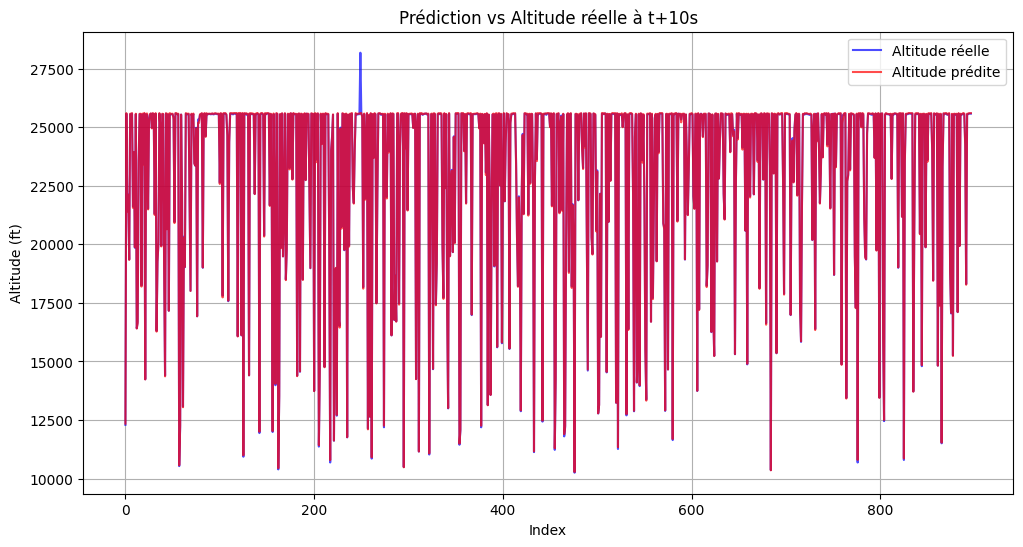

In [115]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Altitude réelle", color="blue", alpha=0.7)
plt.plot(y_pred, label="Altitude prédite", color="red", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Altitude (ft)")
plt.title("Prédiction vs Altitude réelle à t+10s")
plt.legend()
plt.grid(True)
plt.show()